# Linear, LASSO, & Ridge Regression

## Intro

This Jupyter noteboook focuses on making a linear regression on a Canadian car emission dataset that can be found here. The goal is to predict co2 car emissions by training the model on different car features. Then, the model is trained using differend forms of data standardization and the results are compared to find the optimal model.

In [21]:
# Ignore warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [22]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

def get_co2_data():
    co2_data = pd.read_csv('CO2 Emissions_Canada.csv')
    
    return co2_data

get_co2_data()

def data_properties():
    data = get_co2_data()
    
    # Get data info
    print(data.info(), '\n')
    
    # Get statistical properties
    print('Describe data: \n', data.describe(), '\n')
    
    # Check for missing values
    print('Null values: \n', data.isnull().sum())
    
data_properties()
    
def non_num_col_unique_values():
    data = get_co2_data()
    data = data.drop('Model',axis=1)
    non_num_col = data.dtypes == object
    non_num_col = data.columns[non_num_col]

    print( '\n Non-nueric unique values')
    for col in data[non_num_col]:
        unique_values = data[col].unique()
        print(f'Unique values in column "{col}": {unique_values} \n')

non_num_col_unique_values()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

Engine Size(L)                      0.851145
Cylinders                           0.832644
Fuel Consumption City (L/100 km)    0.919592
Fuel Consumption Hwy (L/100 km)     0.883536
Fuel Consumption Comb (L/100 km)    0.918052
Fuel Consumption Comb (mpg)        -0.907426
CO2 Emissions(g/km)                 1.000000
Name: CO2 Emissions(g/km), dtype: float64


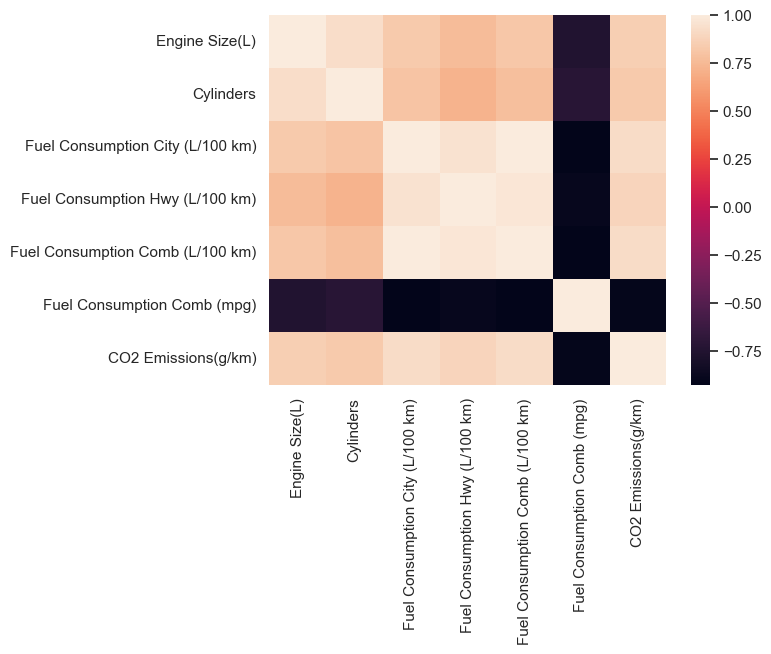

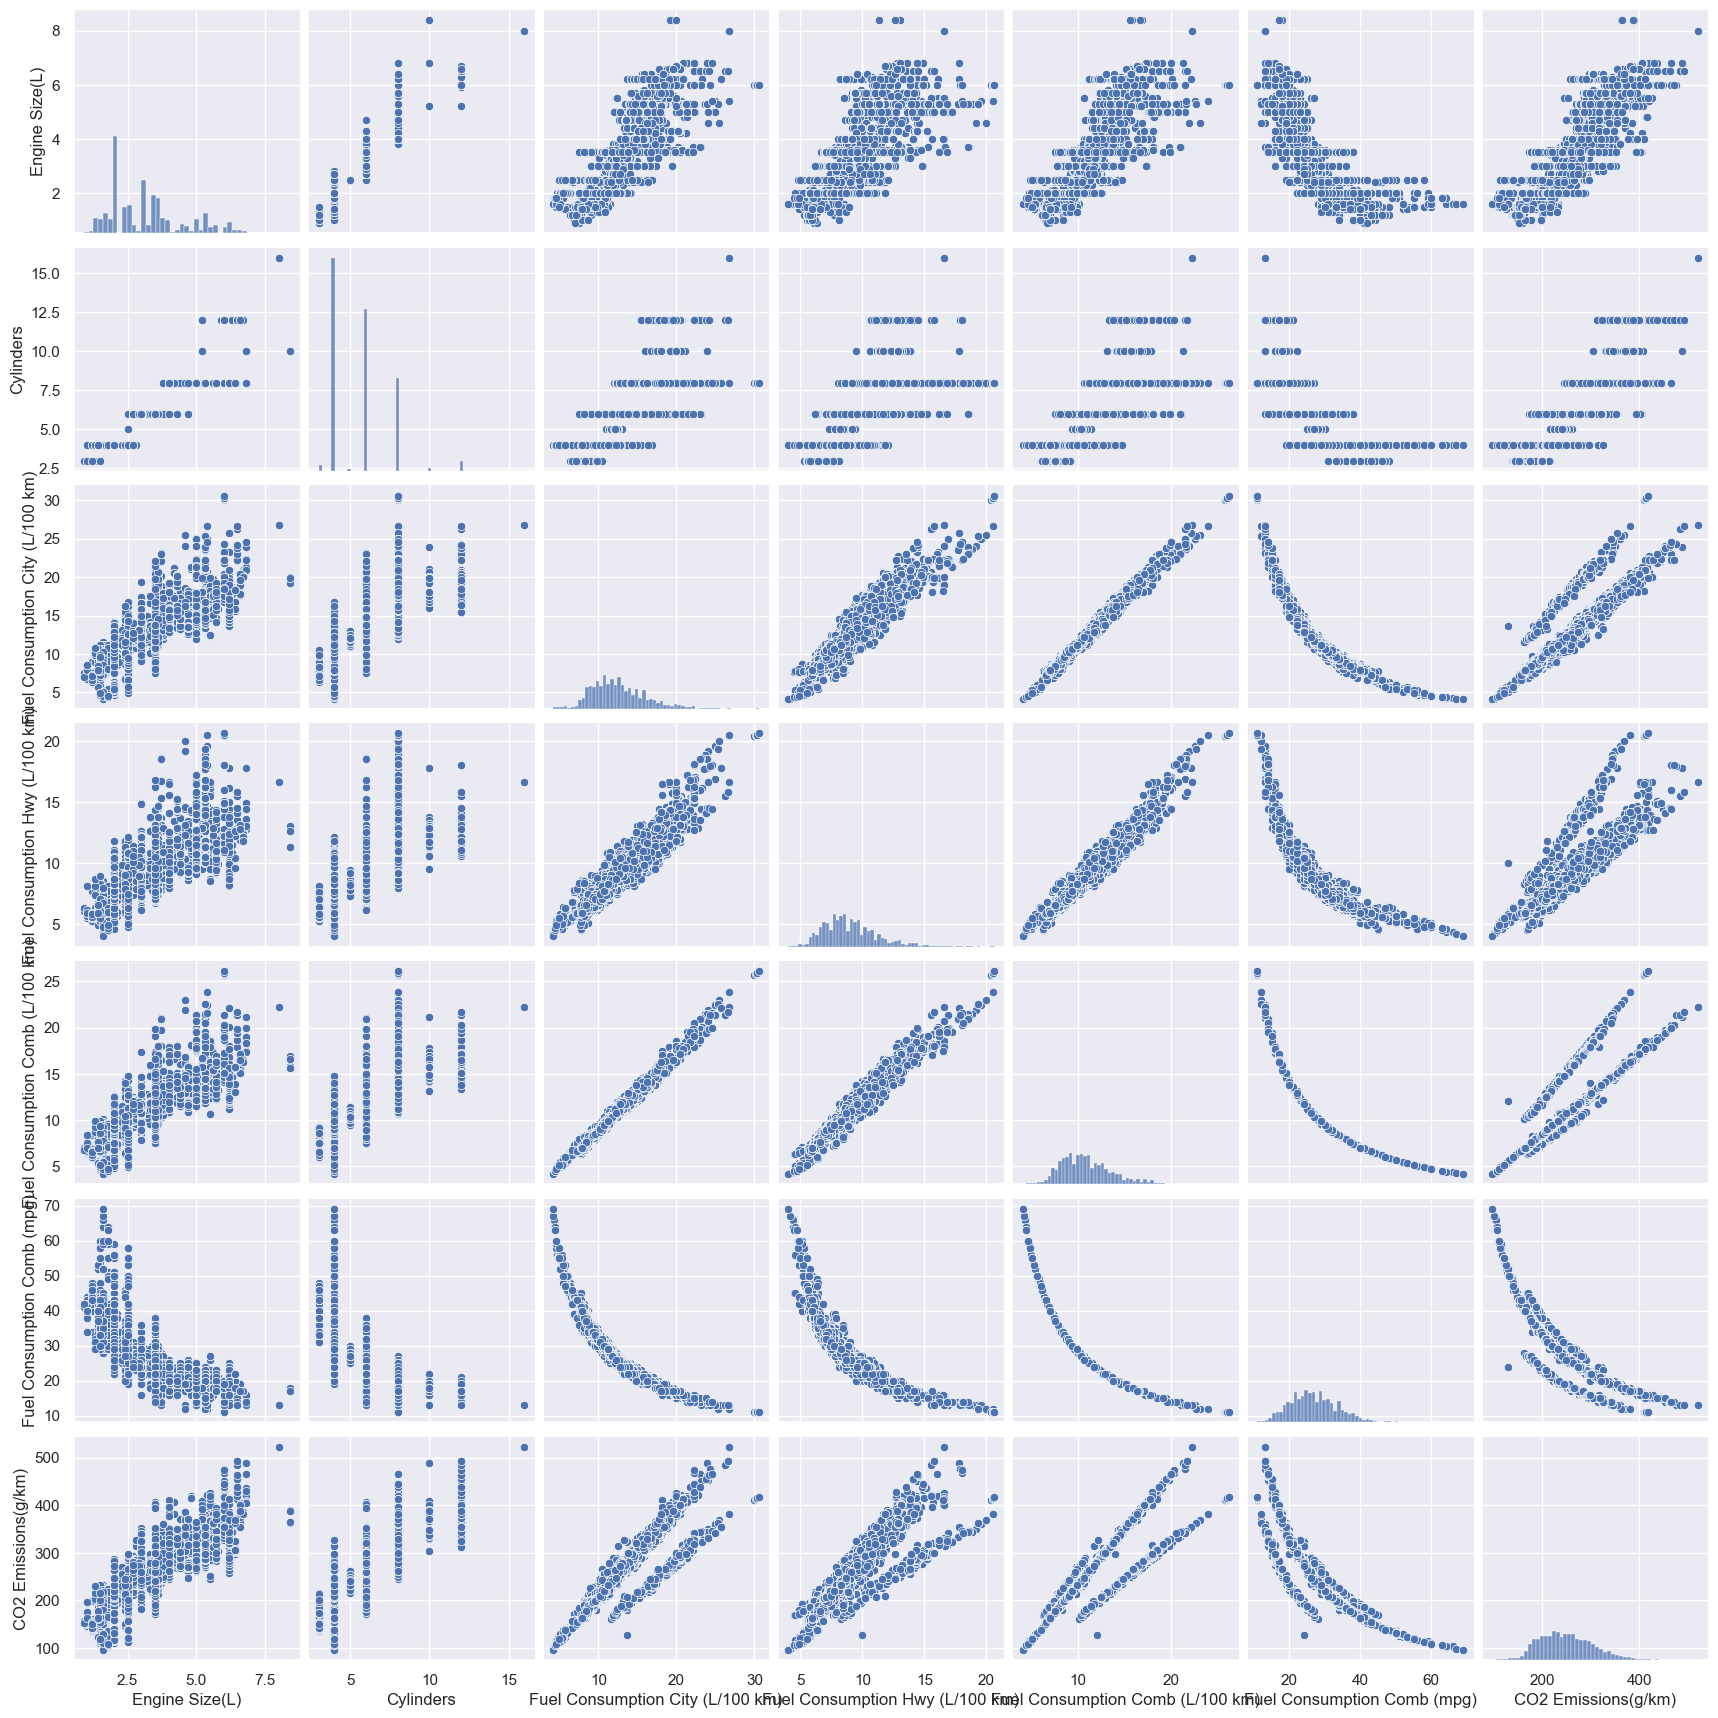

In [23]:
# See which features have the highest correlation with the target variable
import seaborn as sns
def data_corr_matrix():
    data = get_co2_data()
    corr_matrix = data.corr(numeric_only = True)
    corr_matrix['CO2 Emissions(g/km)'].sort_values(ascending = False)
    print(corr_matrix['CO2 Emissions(g/km)'])
    sns.heatmap(corr_matrix)
    
data_corr_matrix()

# A scatter pairplot can also be used to plot the relationships between the features
def data_scat_plot():
    data = get_co2_data()
    sns.pairplot(data)
    plt.show()
    
data_scat_plot()

From the results above all of the numerical features are highly correlated with the target variable "CO2 Emissions (g/km)"

## Normalization

Linear regression analysis requires the target variable to be normally distributed. Making the target normally distributed often leads to better results. The easiest way to check for normalization is by making a histogram of the target variable. D'Agostino's K^2 test can also be used to check for normalization.

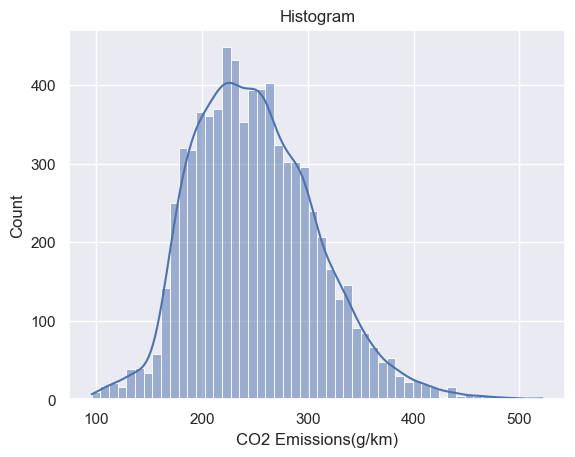

NormaltestResult(statistic=349.5238102344291, pvalue=1.264354797210247e-76)


In [24]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

def target_variable_hist():
    data = get_co2_data()
    
    sns.set()
    ax = plt.axes()
    ax.set(title = 'Histogram')
    sns.histplot(data.loc[:,'CO2 Emissions(g/km)'], common_norm=True, kde=True, ax = ax)
    
    plt.show()

target_variable_hist()

def data_normal_test():
    co2_data = get_co2_data()
    print(normaltest(co2_data['CO2 Emissions(g/km)'].values))
    
data_normal_test()

p-value is extremely low. CO2 Emissions variable is not normally distributed.

### Boxcox Transform

There are multpile methods used to normalize the data. One method to normalize the data is by using SciPy boxcox method.

NormaltestResult(statistic=5.137940214422628, pvalue=0.0766144094339886)


NormaltestResult(statistic=masked_array(data=[349.52381023442985],
             mask=[False],
       fill_value=1e+20), pvalue=array([1.2643548e-76]))


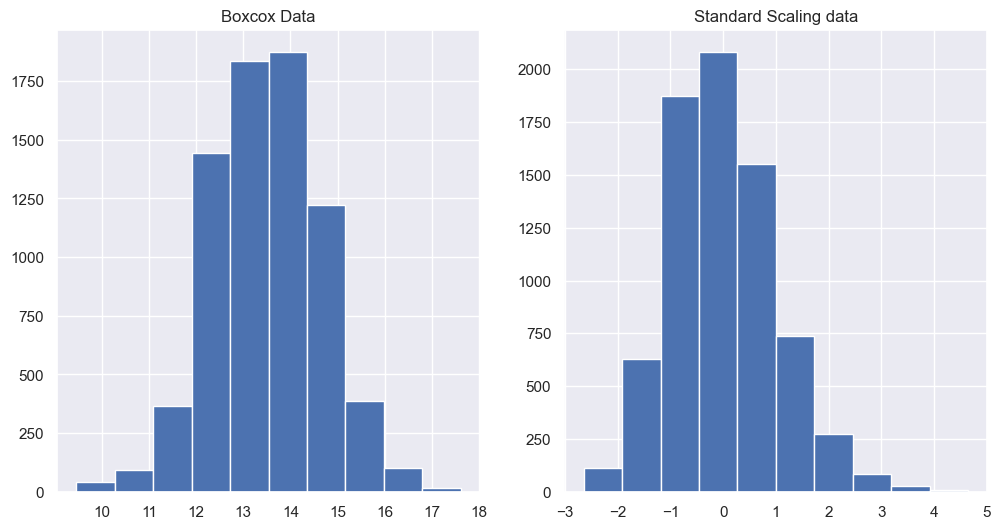

In [25]:
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

def data_boxcox():
    co2_data = get_co2_data()
   
    CO2_boxcox, lam = boxcox(co2_data['CO2 Emissions(g/km)'])
    print(normaltest(CO2_boxcox))
    print('\n')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].hist(CO2_boxcox)
    ax[0].set(title = 'Boxcox Data')
    ss = StandardScaler()
    ss_co2_data = ss.fit_transform(co2_data[['CO2 Emissions(g/km)']])
    print(normaltest(ss_co2_data))
    ax[1].hist(ss_co2_data)
    ax[1].set(title = 'Standard Scaling data')
data_boxcox()

### Feature Selection

Transform categorical columns into numerical columns using sklearns OneHotEncoder methods.

In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def one_hot_enc_data():
    data = get_co2_data()
    data = data.drop('Model',axis=1)
    non_num_col = data.dtypes == object
    non_num_col = data.columns[non_num_col]
 
    # Determine how many extra columns would be created
    num_onehot_cols = (data[non_num_col]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
    # print(num_onehot_cols)
    
    # Create a copy of the data so we can one hot encode it
    data_ohc = data.copy()
   
    
    le = LabelEncoder()
    ohc = OneHotEncoder()    
    
    for col in num_onehot_cols.index:
        
        # Integer encode the string categories
        le_data = le.fit_transform(data_ohc[col]).astype(int)
        
        # Remove orginal column from the data frame
        data_ohc = data_ohc.drop(col, axis = 1)
        
        # One hot encode the data, this returns a sparce array
        new_data = ohc.fit_transform(le_data.reshape(-1,1))
        
        #Create unique column names
        n_cols = new_data.shape[1]
        col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]
        
        # Create a new data frame
        new_df = pd.DataFrame(new_data.toarray(), index = data_ohc.index, columns = col_names)
        
        # Append the new data to the dataframe
        data_ohc = pd.concat([data_ohc, new_df], axis = 1)
    
    return data_ohc

one_hot_enc_data()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Make_0,Make_1,Make_2,...,Vehicle Class_11,Vehicle Class_12,Vehicle Class_13,Vehicle Class_14,Vehicle Class_15,Fuel Type_0,Fuel Type_1,Fuel Type_2,Fuel Type_3,Fuel Type_4
0,2.0,4,9.9,6.7,8.5,33,196,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.4,4,11.2,7.7,9.6,29,221,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.5,4,6.0,5.8,5.9,48,136,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.5,6,12.7,9.1,11.1,25,255,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.5,6,12.1,8.7,10.6,27,244,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,2.0,4,10.7,7.7,9.4,30,219,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7381,2.0,4,11.2,8.3,9.9,29,232,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7382,2.0,4,11.7,8.6,10.3,27,240,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7383,2.0,4,11.2,8.3,9.9,29,232,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Feature Visualization

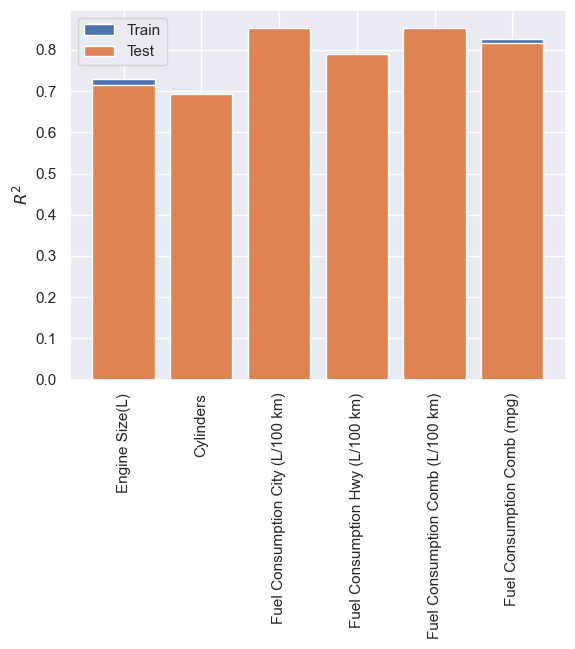

Training R^2 mean value 0.7839764612382868 Testing R^2 mean value 0.7872277319055278 
Training R^2 max value 0.841702887691073 Testing R^2 max value 0.8542109213019045 


In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.special import inv_boxcox
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline


def plot_dis(y,y_pred):
    
    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()
    
    
def feature_visualization():
    data = get_co2_data()
    non_num_col = data.dtypes == object
    non_num_col_names = data.columns[non_num_col]
    co2_data = data.drop(columns = non_num_col_names, axis = 1)
    
    y_col = 'CO2 Emissions(g/km)'
    
    X_data = co2_data.drop(y_col, axis = 1)
    Y_data = co2_data[y_col]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size= 0.3)
    
    lr_model = LinearRegression()
    
    features = list(X_data.columns)
    
    R_2_train = []
    R_2_test = []
    
    for feature in features:
        lr_model.fit(X_train[[feature]], Y_train)
        
        R_2_test.append(lr_model.score(X_test[[feature]], Y_test))
        R_2_train.append(lr_model.score(X_train[[feature]], Y_train))
        
    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

    
feature_visualization()

### Polynomial Features

A linear model can be used to fit nonlinear data by adding plynomial features and then train the data on these extended features. Polynomial features help deal with model underfitting. However, overfitting needs to be taken into consideration when adding polynomial features.

## Linear Regression

There are multiple methods to normalize the data. Below there's a comparison of a linear regression model using different normalization methods.

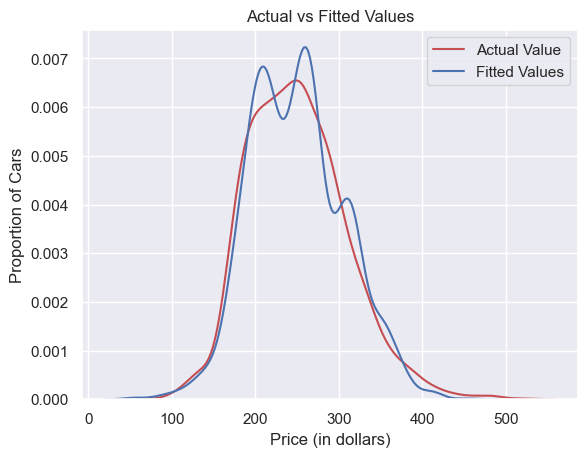

{'Engine Size(L)': 5.387667121160819, 'Cylinders': 7.447774604842039, 'Fuel Consumption City (L/100 km)': 2.488090808641291, 'Fuel Consumption Hwy (L/100 km)': 6.521931597903624, 'Fuel Consumption Comb (L/100 km)': -3.030462673946456, 'Fuel Consumption Comb (mpg)': -3.4232191886178605}


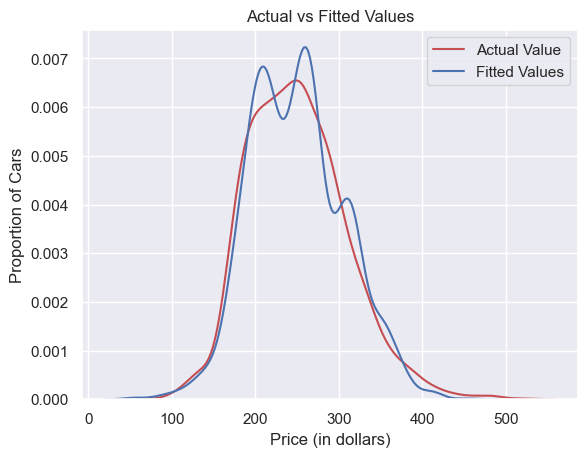

In [28]:


def non_categorical_linear_model():
    data = get_co2_data()
    non_num_col = data.dtypes == object
    non_num_col_names = data.columns[non_num_col]
    co2_data = data.drop(columns = non_num_col_names, axis = 1)
    
    y_col = 'CO2 Emissions(g/km)'
    
    X_data = co2_data.drop(y_col, axis = 1)
    Y_data = co2_data[y_col]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size= 0.3)
    
    lin_model = LinearRegression()
    lin_model.fit(X_train, Y_train)
    
    y_pred = lin_model.predict(X_test)
    
    plot_dis(Y_test, y_pred)
    
    print({col:coef for col,coef in zip(X_data.columns, lin_model.coef_)})
    
    #Apply Standard Scaling
    stand_scal = StandardScaler()
    ss_lr_model = LinearRegression()
    model = Pipeline([('Standard_Scaling', stand_scal),
                     ('Linear_Model', ss_lr_model)])
    
    model.fit(X_train, Y_train)
    ss_y_pred = model.predict(X_test)
    
    plot_dis(Y_test, ss_y_pred)
    
non_categorical_linear_model()




The chart results above show how good is each non numeric feature at predicting CO2 emissions.

### LR Using Boxcox

In [29]:
#Now that we have a normally distributed y-variable, let's test Regression using this transformed target variables.

def LR_model():
    co2_data = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    X_data = co2_data.drop(y_col, axis = 1)
    Y_data = co2_data[y_col]
    
    #Lets add some plynomial features to fit our model to a function of degree 2
    polyfeat = PolynomialFeatures(degree = 2, include_bias=False)
    X_data_pf = polyfeat.fit_transform(X_data)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data_pf,Y_data, test_size= 0.3)
    
    # Boxcox  transform Y_train
    Y_train_bc, lam = boxcox(Y_train)
    
    lr = LinearRegression()
    lr.fit(X_train,Y_train)
    y_pred_bc = lr.predict(X_test)
    
    #y_pred = inv_boxcox(y_pred_bc, lam)
    mse = mean_squared_error(Y_test, y_pred_bc)
    print(r2_score(Y_test, y_pred_bc))
    print(f'Mean Squared Error: {mse}')
    
LR_model()

0.9967169092103624
Mean Squared Error: 10.787959955490054


### Multiple Standardization Methods Comparison

In [23]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

# MSE measures the average of the squares of the errors, that is, the average squared difference between 
# the estimated values and the actual values using the test data
def LR_Model_Comparison():
    data_ohc = one_hot_enc_data()
    #Split the data into x and y where y is the predicted variable
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    LR_X_data = data_ohc[feature_cols]
    LR_Y_data = data_ohc[y_col]
    
    LR_X_train, LR_X_test, LR_Y_train, LR_Y_test = train_test_split(LR_X_data,LR_Y_data, test_size=0.3)
    
    LR = LinearRegression()
        
    error_com_df = {}
    
    scalers = {
        'Standard': StandardScaler(),
        'MinMax': MinMaxScaler(),
        'MaxAbs': MaxAbsScaler()}
    
    for scaler_label, scaler in scalers.items():
        training_set = LR_X_train.copy()
        test_set = LR_X_test.copy()
        
        tarining_set = scaler.fit_transform(training_set)
        test_set = scaler.transform(test_set)
        LR.fit(tarining_set, LR_Y_train)
        predictions = LR.predict(test_set)
        key = scaler_label + 'scaling'
        error_com_df[key] = mean_squared_error(LR_Y_test, predictions)
        
        print(scaler_label, r2_score(LR_Y_test, predictions))
        
    error_com_df = pd.Series(error_com_df)
    print('\n')
    print(error_com_df.to_string())
    print('\n')
    for key, error_val in error_com_df.items():
        print(key, error_val)
        
LR_Model_Comparison()

Standard 0.9927695460730742
MinMax 0.9927696516721989
MaxAbs 0.992769713902013


Standardscaling    24.418390
MinMaxscaling      24.418033
MaxAbsscaling      24.417823


Standardscaling 24.418389758338357
MinMaxscaling 24.41803313334496
MaxAbsscaling 24.4178229733925


## Cross Validation

Cross-validation is a statistical technique used to evaluate the performance of a predictive model. For this notebook it involves dividing the dataset into multiple subsets. The model is trained and tested using all subsets, this ensures that the model performance is evaluated and tested agains all data points.

First we divide the data into k number of subsets, then for each subset, the model is trained on k-1 subsets and is tested on the remaining set. Lastly, the model performance is evaluated, allowing evaluation of the average performance of the model using different train and test sets, reducing the likelihood of overfitting and providing a more reliable estimate of the model's performance.

In [7]:
from sklearn.model_selection import KFold, cross_val_predict

def LR_Cross_Val():
    data_ohc = one_hot_enc_data()
    
    
    #Split the data into x and y where y is the predicted variable
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    scores = []
    
    lr = LinearRegression()
    
    for train_index, test_index in kf.split(X_data):
        X_train, X_test, Y_train, Y_test = (X_data.iloc[train_index, :], X_data.iloc[test_index, :],
                                           Y_data.iloc[train_index], Y_data.iloc[test_index])
        lr.fit(X_train, Y_train)
        
        y_pred = lr.predict(X_test)
        score = r2_score(Y_test.values, y_pred)
        
        scores.append(score)
        
    print(scores)
LR_Cross_Val()

[0.9938944214166029, 0.9928670576901332, 0.9921891620912611, 0.9942171730540939]


In [8]:
from sklearn.model_selection import KFold, cross_val_predict

def LR_Cross_Val2():
    data_ohc = one_hot_enc_data()
    
    
    #Split the data into x and y where y is the predicted variable
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    scores = []
    
    lr = LinearRegression()
    ss = StandardScaler()
    
    for train_index, test_index in kf.split(X_data):
        X_train, X_test, Y_train, Y_test = (X_data.iloc[train_index, :], X_data.iloc[test_index, :],
                                           Y_data.iloc[train_index], Y_data.iloc[test_index])
        X_train_ss = ss.fit_transform(X_train)
        X_test_ss = ss.transform(X_test)
        lr.fit(X_train_ss, Y_train)
        
        y_pred = lr.predict(X_test_ss)
        score = r2_score(Y_test.values, y_pred)
        
        scores.append(score)
        
    print(scores)
LR_Cross_Val2()

[-4.1925085429571907e+18, -1.4207411577184256e+19, 0.9936871696404903, 0.9937880165560958]


## Regularization

Regularization allows to dumb down the model by reducing or eliminating feature coefficients.

### Hyperparameter Tunning

Hyperparameter tunning uses cross validation to determine which hyperparameters are most likely to create a model that works well with data that's different from the training and test sets provided.

### LASSO Regression

LASSO regresion uses L1 normalization to reduce or eliminate the magnitude of the feature coefficients. LASSOCV function does not allow the scoring function to be used. Instead a root mean squared error function can be created to evaluate the error on the final model

C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+04, tolerance: 1.870e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+04, tolerance: 1.908e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e+04, toleranc

[0.9973346695698733, 0.9972737245379328, 0.997500131835332, 0.997566431146508, 0.9953181278698786]


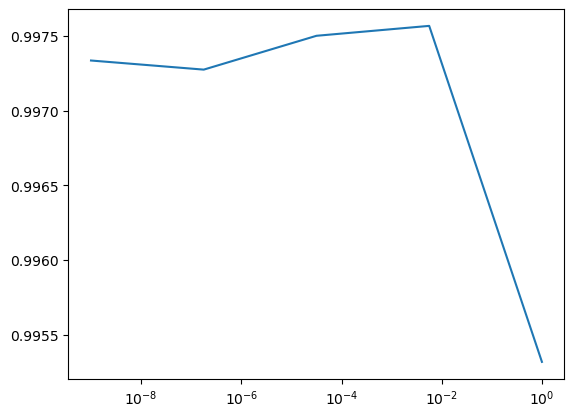

In [9]:
from sklearn.linear_model import Lasso

def Lasso_Reg():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    scores  = []
    
    polyfeat = PolynomialFeatures(degree = 2)
    standscale = StandardScaler()
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    alphas = np.geomspace(1e-9, 1, num = 5)
    
    for alpha in alphas:
        lasso_reg = Lasso(alpha, max_iter = 1000)
        
        model = Pipeline([('Polynomial Features', polyfeat),
                        ('Standard Scaler', standscale),
                        ('Lasso Regression', lasso_reg)])
    
        predictions = cross_val_predict(model, X_data, Y_data, cv = kf)
        
        score = r2_score(Y_data, predictions)
        
        scores.append(score)
    
    print(scores)
    
    plt.semilogx(alphas, scores);
Lasso_Reg()

### Ridge Regression

Ridge regression uses L2 normalization to reduce the magnitude of the feature coefficients. This is helpful when working with high variance.

[0.9970822433449268, 0.9973489002416306, 0.9974452589438307, 0.9975770963391751, 0.9974736572484472]


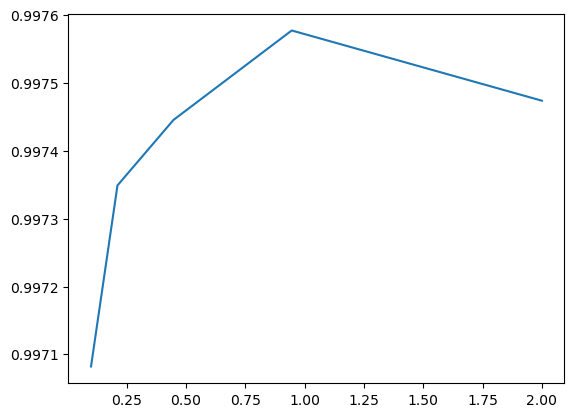

In [12]:
from sklearn.linear_model import Ridge

def Ridge_Reg():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    scores  = []
    
    polyfeat = PolynomialFeatures(degree = 2)
    standscale = StandardScaler()
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    alphas = np.geomspace(0.1, 2, 5)
    
    for alpha in alphas:
        RidgeReg = Ridge(alpha = alpha, max_iter=1000)
        
        model = Pipeline([('Polynomial Features', polyfeat),
                          ('Standard Scaler', standscale),
                          ('Ridge Regression', RidgeReg)])
    
        predictions = cross_val_predict(model, X_data, Y_data, cv = kf)
        
        score = r2_score(Y_data, predictions)
        
        scores.append(score)
    
    print(scores)
    
    plt.plot(alphas, scores);
Ridge_Reg()

###  Grid Search CV

GridSearchCV takes a model (or pipeline) with a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls it "best estimator". Then it trains again on all data with the best hyper-parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

def Ridge_Grid_Search():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    kf = KFold(shuffle = True, n_splits = 4)
    
    model = Pipeline([("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge())])
    
    params = {'polynomial_features__degree': [1,2,3],
              'ridge_regression__alpha': np.geomspace(4,20, 10)
             }
    
    grid_search = GridSearchCV(model, params, cv = kf)
    grid_search.fit(X_data, Y_data)

    print(grid_search.best_estimator_, grid_search.best_params_)
    y_predict = grid_search.predict(X_data)
    print(r2_score(Y_data, y_predict))
    
Ridge_Grid_Search()

### Elastic Net

ElasticNetCV is a combination of L1 (LASSO) and L2 (Ridge)regularization.

In [10]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [13]:
from sklearn.linear_model import ElasticNetCV

def Elastic_Net_CV_model():
    data_ohc = one_hot_enc_data()
    y_col = 'CO2 Emissions(g/km)'
    
    feature_cols = [i for i in data_ohc.columns if i != y_col]
    X_data = data_ohc[feature_cols]
    Y_data = data_ohc[y_col]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, shuffle = True, test_size=0.3)
    alphas = np.array([1e-5, 5e-5, 0.0001, 0.0005])
    l1_ratios = np.linspace(0.1, 0.9, 9)
    
    elastic_Net_CV = ElasticNetCV(alphas=alphas, l1_ratio= l1_ratios, max_iter=10000)
    elastic_Net_CV.fit(X_train,Y_train)
    
    y_pred = elastic_Net_CV.predict(X_test)
    elastic_Net_CV_rmse = rmse(Y_test, y_pred)
    
    print('best fit parameters:  ', elastic_Net_CV.alpha_, elastic_Net_CV.l1_ratio_, elastic_Net_CV_rmse )
    
Elastic_Net_CV_model()

C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48223.48005844685, tolerance: 1366.6202331318018
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31055.957013215055, tolerance: 1366.6202331318018
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4712.870729466806, tolerance: 1366.6202331318018
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683

C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28141.6393648958, tolerance: 1401.3877992744863
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41503.41975270443, tolerance: 1404.842753470375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30846.893029354032, tolerance: 1404.842753470375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: C

C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25616.45604409399, tolerance: 1401.3877992744863
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18100.04094387267, tolerance: 1401.3877992744863
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32376.85609020935, tolerance: 1404.842753470375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: 

C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10010.247242287027, tolerance: 1428.6015570599614
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17064.858160967808, tolerance: 1366.6202331318018
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6185.073378438952, tolerance: 1366.6202331318018
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:68

best fit parameters:   1e-05 0.1 4.7541602180008145


C:\Users\palom\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.484e+04, tolerance: 1.748e+03
  model = cd_fast.enet_coordinate_descent(
